In [6]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import t
import zipfile
import xarray as xr
import tempfile

In [12]:

# Path to the zip file
zip_path = r'C:\YEAR1\NMVOC\Data\data_Meteo\PBL_era5\3adcc5350c371aec9a88a809f935cb56.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files in zip:", z.namelist())
    netcdf_filename = z.namelist()[0]  # e.g. 'data_stream.nc'
    
    # Create a temporary file without deleting it automatically
    tmp = tempfile.NamedTemporaryFile(suffix='.nc', delete=False)
    try:
        tmp.write(z.read(netcdf_filename))
        tmp.close()  # Manually close so xarray can access it

        # Now open with xarray
        ds = xr.open_dataset(tmp.name)
        print(ds)

        # Convert to DataFrame
        df = ds.to_dataframe().reset_index()
        print(df.head())
        
    finally:
        ds.close()  # Close the xarray dataset to release the file
        os.remove(tmp.name)  # Clean up temp file manually

# Show part of the DataFrame
print(df.head())



Files in zip: ['data_stream-oper_stepType-instant.nc']
<xarray.Dataset>
Dimensions:     (valid_time: 26304, latitude: 49, longitude: 45)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2018-01-01 ... 2020-12-31T23:00:00
  * latitude    (latitude) float64 48.0 47.75 47.5 47.25 ... 36.5 36.25 36.0
  * longitude   (longitude) float64 8.0 8.25 8.5 8.75 ... 18.25 18.5 18.75 19.0
    expver      (valid_time) object ...
Data variables:
    blh         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-16T10:36 GRIB to CDM+CF via cfgrib-0.9.1...
  valid_time  latitude  longitude  number expver          blh
0 2018-01-01      48.0       8.00       0   0001  1040

In [13]:
# Your target coordinates
target_lat = 44.193205336
target_lon = 10.7014294564

# Step 1: Select the nearest point
# (Assuming the dataset uses 'latitude' and 'longitude' as coordinate names)
blh_at_location = ds['blh'].sel(
    latitude=target_lat,
    longitude=target_lon,
    method='nearest'  # finds the nearest grid point
)

# Step 2: Convert to pandas DataFrame (optional)
blh_df = blh_at_location.to_dataframe().reset_index()

# Step 3: Show the result
print(blh_df.head())

           valid_time  number  latitude  longitude expver         blh
0 2018-01-01 00:00:00       0     44.25      10.75   0001   89.063461
1 2018-01-01 01:00:00       0     44.25      10.75   0001   88.888565
2 2018-01-01 02:00:00       0     44.25      10.75   0001   96.056602
3 2018-01-01 03:00:00       0     44.25      10.75   0001  102.910378
4 2018-01-01 04:00:00       0     44.25      10.75   0001  103.156937


In [15]:
print(blh_df.tail())

               valid_time  number  latitude  longitude expver         blh
26299 2020-12-31 19:00:00       0     44.25      10.75   0001  168.987625
26300 2020-12-31 20:00:00       0     44.25      10.75   0001  164.745636
26301 2020-12-31 21:00:00       0     44.25      10.75   0001  127.280563
26302 2020-12-31 22:00:00       0     44.25      10.75   0001  109.030487
26303 2020-12-31 23:00:00       0     44.25      10.75   0001  120.679153


Nearest Latitude: 44.25, Nearest Longitude: 10.75


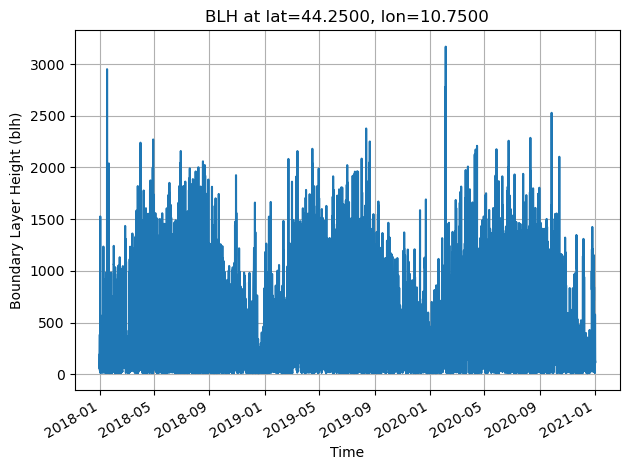

In [16]:
import matplotlib.pyplot as plt

# Your target coordinates
target_lat = 44.193205336
target_lon = 10.7014294564

# Find the nearest grid point
lat_idx = ds.latitude.sel(latitude=target_lat, method='nearest')
lon_idx = ds.longitude.sel(longitude=target_lon, method='nearest')

print(f"Nearest Latitude: {float(lat_idx.values)}, Nearest Longitude: {float(lon_idx.values)}")

# Extract the 'blh' values at that location over time
blh_series = ds['blh'].sel(latitude=lat_idx, longitude=lon_idx)


blh_series.plot()
plt.title(f"BLH at lat={float(lat_idx.values):.4f}, lon={float(lon_idx.values):.4f}")
plt.ylabel('Boundary Layer Height (blh)')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()


valid_time
0      92.673622
1      90.268532
2      90.522736
3      92.612450
4      94.086304
5      99.337753
6     128.848206
7     236.333160
8     410.221283
9     606.734131
10    748.914734
11    902.028015
12    985.326782
13    999.058960
14    945.177307
15    813.389404
16    618.157410
17    407.441864
18    223.633194
19    150.673660
20    123.475861
21    111.309036
22     98.242638
23     97.437935
Name: blh, dtype: float32


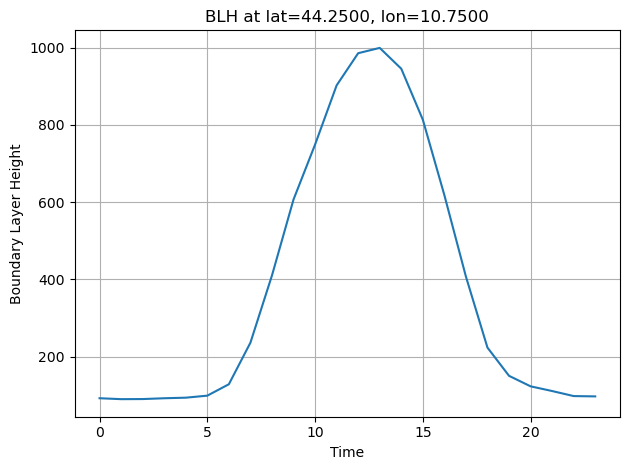

In [20]:
# Ensure time is datetime format
time = ds['valid_time'].to_index()

# Select nearest lat/lon as before
lat_idx = ds.latitude.sel(latitude=target_lat, method='nearest')
lon_idx = ds.longitude.sel(longitude=target_lon, method='nearest')

# Extract BLH series
blh_series = ds['blh'].sel(latitude=lat_idx, longitude=lon_idx)

# Convert to pandas Series with datetime index
blh_df = blh_series.to_series()
blh_df.index = pd.to_datetime(blh_df.index)

# Group by hour and compute mean
blh_by_hour = blh_df.groupby(blh_df.index.hour).mean()

# Print grouped result
print(blh_by_hour)

blh_by_hour.plot()
plt.title(f"BLH at lat={float(lat_idx.values):.4f}, lon={float(lon_idx.values):.4f}")
plt.ylabel('Boundary Layer Height')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()